### Author: Sangeeths Chandrakunmar

### GBM Model

### Import Libraries

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot

### Importiere verarbeitete Daten

In [9]:
file_path = 'ds_salaries.csv'
ds_salaries = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
ds_salaries.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


### Data Cleaning and Preprocessing

In [10]:
ds_salaries_cleaned = ds_salaries.drop(['salary', 'salary_currency'], axis=1)


categorical_cols = ds_salaries_cleaned.select_dtypes(include=['object', 'category']).columns
numerical_cols = ds_salaries_cleaned.select_dtypes(include=['int64', 'float64']).columns.drop('salary_in_usd')


numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


X = ds_salaries_cleaned.drop('salary_in_usd', axis=1)
y = ds_salaries_cleaned['salary_in_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

### GBM Regressor

In [11]:
# Defining the Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(random_state=0)

# Training the model
gb_regressor.fit(X_train_transformed, y_train)

# Predicting and evaluating the model
y_train_pred_gb = gb_regressor.predict(X_train_transformed)
y_test_pred_gb = gb_regressor.predict(X_test_transformed)

mse_train_gb = mean_squared_error(y_train, y_train_pred_gb)
r2_train_gb = r2_score(y_train, y_train_pred_gb)

mse_test_gb = mean_squared_error(y_test, y_test_pred_gb)
r2_test_gb = r2_score(y_test, y_test_pred_gb)

(mse_train_gb, r2_train_gb, mse_test_gb, r2_test_gb)


(1992747216.7260382,
 0.4884178394839702,
 2678040556.9129496,
 0.37231693447494574)

### GBM Regressor with Grid Search

In [12]:
# Defining the parameter grid for GridSearchCV with GBM
gbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10]
}

# Creating the GridSearchCV object for GBM
gbm_grid_search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=0), 
                               param_grid=gbm_param_grid, 
                               cv=3, 
                               n_jobs=-1, 
                               verbose=2)

# Fitting GridSearchCV to the data
gbm_grid_search.fit(X_train_transformed, y_train)

# Extracting the best estimator
best_gbm = gbm_grid_search.best_estimator_

# Evaluating the best model found by GridSearchCV
y_train_pred_best_gbm = best_gbm.predict(X_train_transformed)
y_test_pred_best_gbm = best_gbm.predict(X_test_transformed)

best_gbm_params = gbm_grid_search.best_params_
mse_train_best_gbm = mean_squared_error(y_train, y_train_pred_best_gbm)
r2_train_best_gbm = r2_score(y_train, y_train_pred_best_gbm)

mse_test_best_gbm = mean_squared_error(y_test, y_test_pred_best_gbm)
r2_test_best_gbm = r2_score(y_test, y_test_pred_best_gbm)

best_gbm_params, (mse_train_best_gbm, r2_train_best_gbm, mse_test_best_gbm, r2_test_best_gbm)


Fitting 3 folds for each of 81 candidates, totalling 243 fits


({'learning_rate': 0.1,
  'max_depth': 4,
  'min_samples_split': 2,
  'n_estimators': 200},
 (1797247812.0128298,
  0.5386068484075897,
  2678449527.37897,
  0.37222107937851756))

Text(0, 0.5, 'Feature Importance Score')

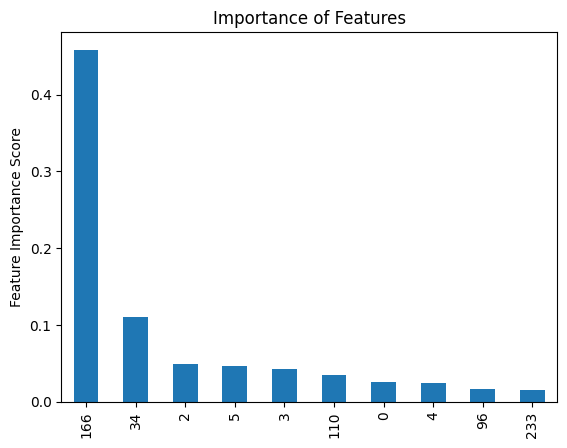

In [13]:
feat_imp = pd.Series(gb_regressor.feature_importances_).sort_values(ascending=False).head(10)
feat_imp.plot(kind='bar', title='Importance of Features')
pyplot.ylabel('Feature Importance Score')

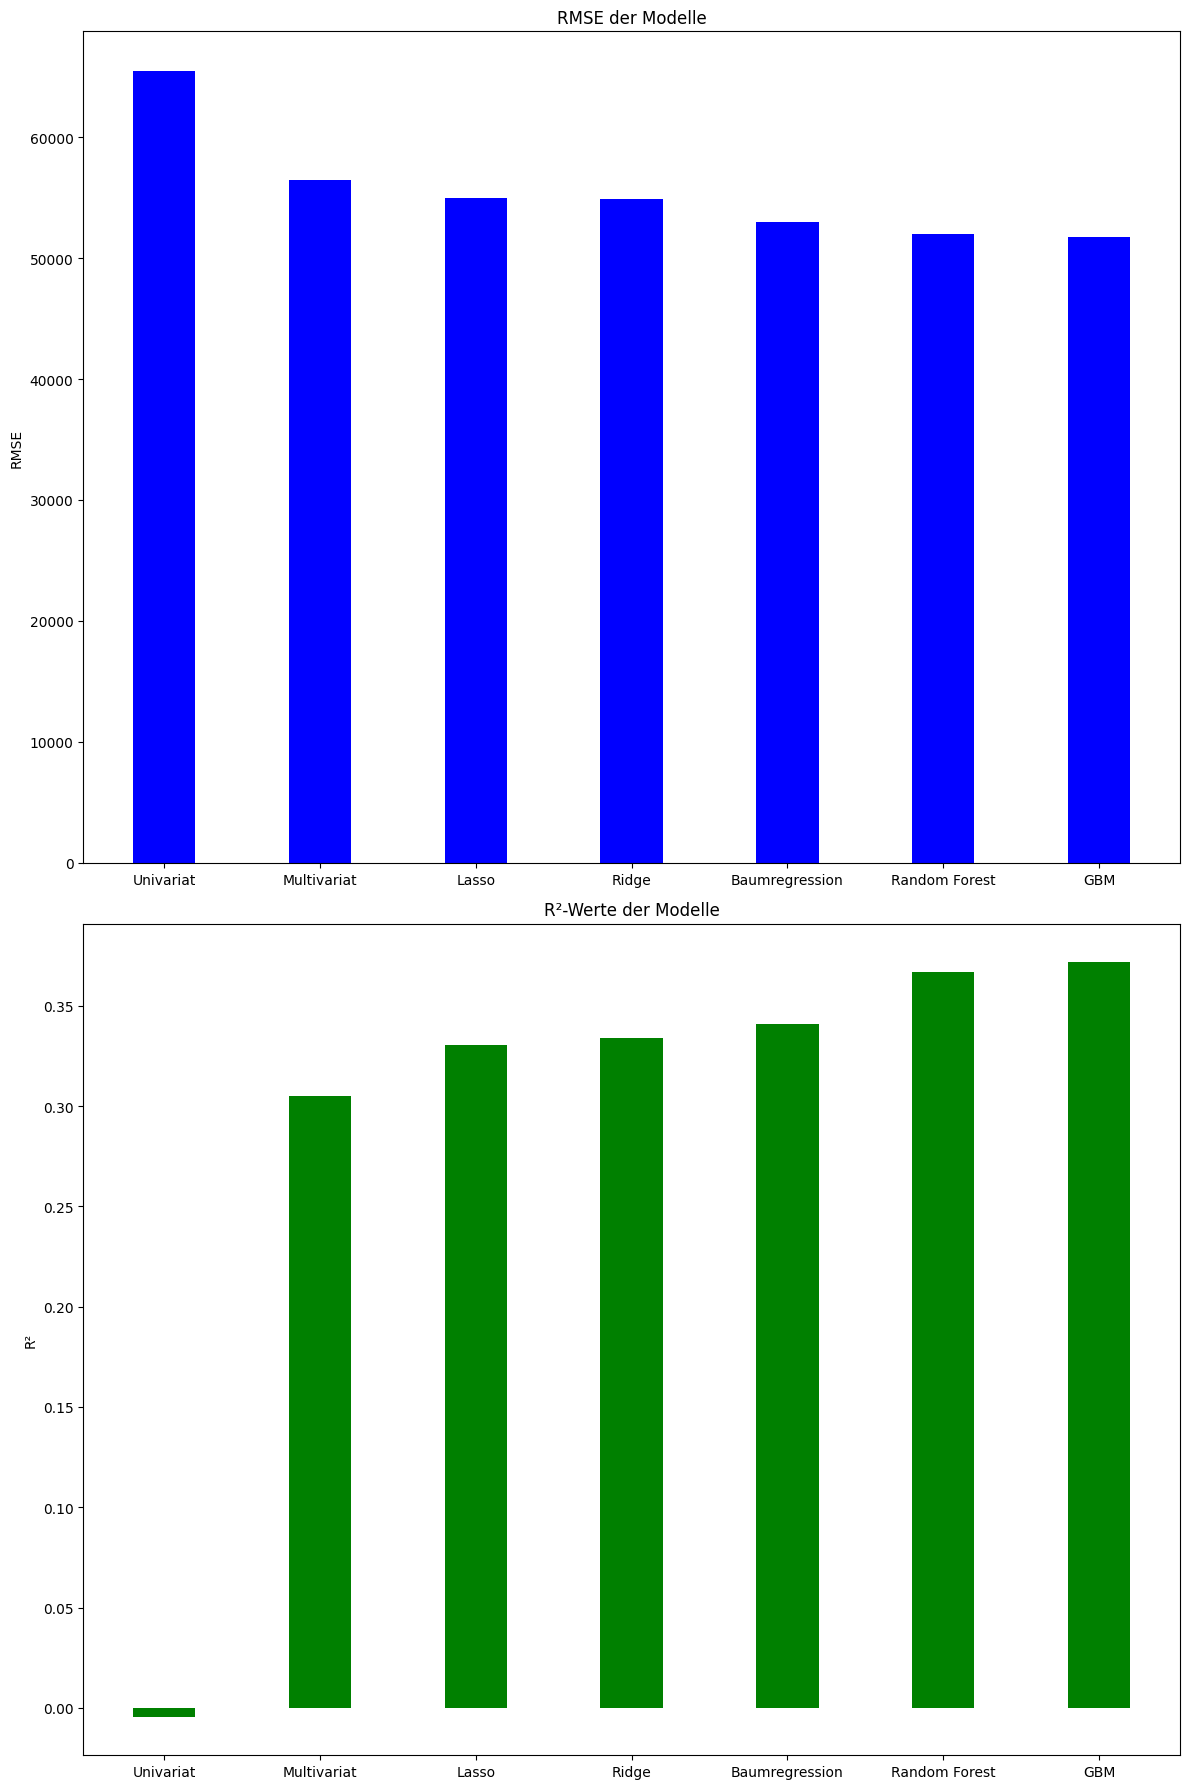

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Daten (RMSE, R² und MSE) für jedes Modell
modelle = ['Univariat', 'Multivariat', 'Lasso', 'Ridge', 
           'Baumregression', 'Random Forest', 'GBM']

# RMSE-Werte für jedes Modell
rmse = [65474.70, 56451.33, 54998.28, 54850.06, 
        (2.811 * 10**9)**0.5,  # Umrechnung von MSE in RMSE
        (2.703 * 10**9)**0.5, 
        (2.678 * 10**9)**0.5]

# R²-Werte für jedes Modell
r_quadrat = [-0.00478, 0.3052, 0.3304, 0.3339, 0.341, 0.367, 0.372]


x = np.arange(len(modelle))  # die Label-Positionen

# Grafiken erstellen
fig, ax = plt.subplots(2, 1, figsize=(12, 18))

# RMSE
ax[0].bar(x, rmse, color='b', width=0.4)
ax[0].set_title('RMSE der Modelle')
ax[0].set_xticks(x)
ax[0].set_xticklabels(modelle)
ax[0].set_ylabel('RMSE')

# R²
ax[1].bar(x, r_quadrat, color='g', width=0.4)
ax[1].set_title('R²-Werte der Modelle')
ax[1].set_xticks(x)
ax[1].set_xticklabels(modelle)
ax[1].set_ylabel('R²')


# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()
